In [15]:
import pickle 
import qiskit

# # with open('circuit.pkl', 'wb') as f:
# #     pickle.dump(circuit, f)

# with open('circuit.pkl', 'rb') as f:
#     circuit = pickle.load(f)
# # limit = 17

# # print(circuit.data)

# # for i in range(1, limit):
# #     print("Removing operation:", circuit.data[-i])
# #     del circuit.data[-1]

# for element in circuit.data:
#     print(element)
# circuit.draw('mpl', style='bw', fold=100)


num_qubits = 32
num_partitions = 4
qpu_info = [int(num_qubits/num_partitions) + 1] * num_partitions


from MLFM_GCP.circuits.cp_fraction import *

circuit = cp_fraction(num_qubits, num_qubits, 0.5)

# circuit.draw('mpl', style='bw', fold=100)

In [16]:
from qiskit.converters import circuit_to_dag
from qiskit.dagcircuit.dagnode import DAGOpNode

def get_reg_mapping(circuit):
    qubit_indeces = {}
    index = 0
    for reg in circuit.qregs:
        for n in range(reg.size):
            qubit_indeces[(reg.name,n)] = index
            index += 1
    return qubit_indeces

def circuit_to_gate_layers(circuit):
    "Uses qiskit DAG circuit to group gates into sublists by layer/timestep of the circuit"
    dag = circuit_to_dag(circuit)
    layers = list(dag.multigraph_layers())
    layer_gates = []
    qubit_mapping = get_reg_mapping(circuit)
    for layer in layers:
        layer_info = []
        for node in layer:
            if isinstance(node, DAGOpNode):
                gate_info = [node.name, [qubit_mapping[(qubit._register.name,qubit._index)] for qubit in node.qargs],[qubit._register.name for qubit in node.qargs],node.op.params]
                layer_info.append(gate_info)
        layer_gates.append(layer_info)
    del layer_gates[-1]
    del layer_gates[0]
    return layer_gates

def layer_list_to_dict(layers):
    d = {}
    for i,layer in enumerate(layers):
        d[i] = []
        for gate in layer:
            gate_dict = {}
            name = gate[0]
            qargs = gate[1]
            qregs = gate[2]
            params = gate[3]
            if gate[0] != 'barrier' and gate[0] != 'measure':
                if len(gate) < 5:
                    if len(qargs) < 2:
                        gate_dict['type'] = 'single-qubit'
                    elif len(qargs) == 2:
                        gate_dict['type'] = 'two-qubit'
                    gate_dict['name'] = name
                    gate_dict['qargs'] = qargs
                    gate_dict['qregs'] = qregs
                    gate_dict['params'] = params
                else:
                    gate_dict['type'] = 'group'
                    gate_dict['root'] = qargs[0]
                    gate_dict['sub-gates'] = []
                    gate1 = {}
                    gate1['type'] = 'two-qubit'
                    gate1['name'] = name
                    gate1['time'] = i
                    gate1['qargs'] = qargs
                    gate1['qregs'] = qregs
                    gate1['params'] = params
                    gate_dict['sub-gates'].append(gate1)
                    for j in range(5,len(gate)):
                        gate_i_list = gate[j]
                        gate_i = {}
                        if gate_i_list[0] == gate_i_list[1]:
                            gate_i['type'] = 'single-qubit'
                            l = 1
                        else:
                            gate_i['type'] = 'two-qubit'
                            l = 2
                        gate_i['name'] = gate_i_list[-1]
                        gate_i['qargs'] = [gate_i_list[0],gate_i_list[1]]
                        gate_i['qregs'] = ['q' for _ in range(l)]
                        gate_i['params'] = gate_i_list[-2]
                        gate_i['time'] = gate_i_list[2]
                        gate_dict['sub-gates'].append(gate_i)
                d[i].append(gate_dict)
    return d




In [18]:
layers = circuit_to_gate_layers(circuit)

layers_dict = layer_list_to_dict(layers)
# for layer in layers_dict:
#     for gate in layers_dict[layer]:
#         print(gate)


# layers_grouped = group_distributable_packets_dict(layers_dict,group_anti_diags=False)
# for layer in layers_grouped:
#     for gate in layers_grouped[layer]:
#         print(gate)

layers_grouped = layers_dict

In [19]:
from MLFM_GCP.graphs.GCP_hypergraph import QuantumCircuitHyperGraph

basic_graph = QuantumCircuitHyperGraph(circuit, map_circuit=True, group_gates=False)



graph = QuantumCircuitHyperGraph(circuit, map_circuit=False)

graph.add_time_neighbor_edges(graph.depth, range(graph.num_qubits))
graph.layers = layers_grouped
graph.map_circuit_to_hypergraph() 

In [20]:
from MLFM_GCP.partitioning.FM.FM_methods import set_initial_partitions


partition = set_initial_partitions(qpu_info, num_qubits, circuit.depth(), num_partitions=num_partitions, reduced=True)

from MLFM_GCP.drawing.mpl_drawing import hypergraph_to_matplotlib

# hypergraph_to_matplotlib(basic_graph, num_qubits=num_qubits, assignment=partition, qpu_info=qpu_info, depth=circuit.depth(), xscale=10*circuit.depth(), yscale=6*num_qubits)
# hypergraph_to_matplotlib(graph, num_qubits=num_qubits, assignment=partition, qpu_info=qpu_info, depth=circuit.depth(), xscale=10*circuit.depth(), yscale=6*num_qubits)

In [21]:
standard_grouped_graph = QuantumCircuitHyperGraph(circuit, map_circuit=True, group_gates=True)

# hypergraph_to_matplotlib(standard_grouped_graph, num_qubits=num_qubits, assignment=partition, qpu_info=qpu_info, depth=circuit.depth(), xscale=10*circuit.depth(), yscale=6*num_qubits)

Initial cost: 183
All passes complete.
Final cost: 140
Best cost at level 0: 140
Initial cost: 140
All passes complete.
Final cost: 131
Best cost at level 1: 131
Initial cost: 131
All passes complete.
Final cost: 125
Best cost at level 2: 125
Initial cost: 125
All passes complete.
Final cost: 121
Best cost at level 3: 121
Initial cost: 121
All passes complete.
Final cost: 118
Best cost at level 4: 118
Initial cost: 118
All passes complete.
Final cost: 118
Best cost at level 5: 118
Layer 0
Log to phys {0: Qubit(QuantumRegister(9, 'part2_data'), 0), 1: Qubit(QuantumRegister(9, 'part0_data'), 0), 2: Qubit(QuantumRegister(9, 'part3_data'), 0), 3: Qubit(QuantumRegister(9, 'part0_data'), 1), 4: Qubit(QuantumRegister(9, 'part1_data'), 0), 5: Qubit(QuantumRegister(9, 'part0_data'), 2), 6: Qubit(QuantumRegister(9, 'part1_data'), 1), 7: Qubit(QuantumRegister(9, 'part1_data'), 2), 8: Qubit(QuantumRegister(9, 'part0_data'), 3), 9: Qubit(QuantumRegister(9, 'part1_data'), 3), 10: Qubit(QuantumRegist

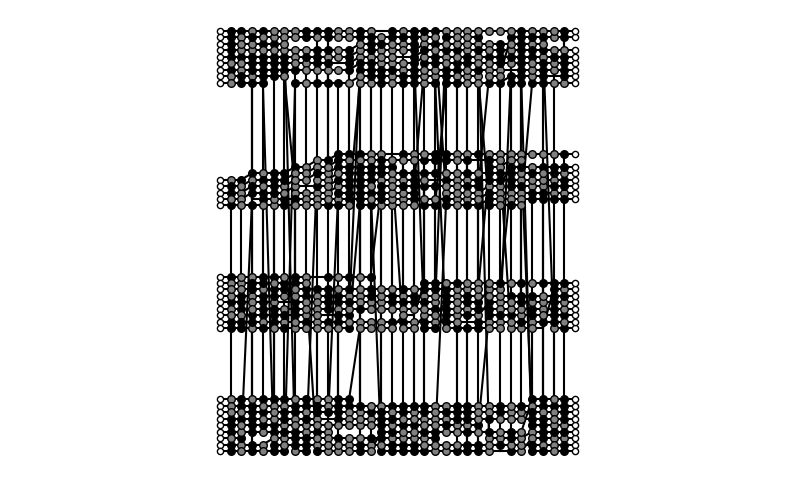

In [22]:
from MLFM_GCP.circuit_extraction.circuit_extractor import PartitionedCircuitExtractor

from MLFM_GCP.partitioning.FM.multilevel_FM import MLFM_recursive

limit = 'qubit'

assignment_list, cost_list, time_list = MLFM_recursive(graph,
                                        partition,  
                                        qpu_info, 
                                        limit = 'qubit',
                                        log=True)

optimised_assignment = assignment_list[np.argmin(cost_list)]

mpl_fig = hypergraph_to_matplotlib(
    graph, 
    num_qubits,
    optimised_assignment,
    qpu_info,
    circuit.depth(),
    xscale=10*circuit.depth(),
    yscale=6*num_qubits
)

extractor = PartitionedCircuitExtractor(graph=graph, 
                                         partition_assignment=optimised_assignment, 
                                         qpu_info=qpu_info, 
                                         comm_info=[2 for _ in range(num_partitions)])

basic_partitioned_circuit = extractor.extract_partitioned_circuit()

print(f"Depth of partitioned circuit: {basic_partitioned_circuit.depth()}")

from qiskit import transpile

circuit_EPR = transpile(basic_partitioned_circuit, basis_gates=['cp', 'u', 'EPR'])

print(f'Number of EPR pairs in circuit {circuit_EPR.count_ops()['EPR']}')

In [23]:
# circuit_EPR.draw('mpl', style='bw', fold=100)

In [24]:
from qiskit import ClassicalRegister

creg = ClassicalRegister(8, name="c")
measured_circuit = circuit.copy()
measured_circuit.measure_all()

In [25]:
# from qiskit_aer.primitives import SamplerV2
# from qiskit.visualization import plot_histogram
# import matplotlib.pyplot as plt


# sampler = SamplerV2()

# job = sampler.run([measured_circuit], shots=4096)
# job_result = job.result()
# data = job_result[0].data

# counts_base = data['meas'].get_counts()
# fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# plot_histogram(counts_base, bar_labels=False, ax=ax)
# ax.set_xticks([])


In [26]:
# part_circuit_dec = basic_partitioned_circuit.decompose().decompose().decompose()

# sampler = SamplerV2()

# job = sampler.run([part_circuit_dec], shots=4096)
# job_result = job.result()
# data = job_result[0].data

# counts_part2 = data['result'].get_counts()

# fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# plot_histogram(data['result'].get_counts(),bar_labels=False,ax=ax)

# ax.set_xticks([])


In [27]:
# import numpy as np

# def get_fidelity(counts1, counts2, shots):
#     for key in counts1:
#         digits = len(key)
#         break
#     norm = 0    
#     max_string = '1'*digits
#     integer = int(max_string, 2)
#     for i in range(integer+1):
#         binary = bin(i)
#         binary = binary[2:]
#         binary = '0'*(digits-len(binary)) + binary
#         if binary in counts1:
#             counts1_val = counts1[binary]/shots
#         else:
#             counts1_val = 0
#         if binary in counts2:
#             counts2_val = counts2[binary]/shots
#         else:
#             counts2_val = 0
#         norm += np.abs(counts1_val - counts2_val)
#     return norm**2



In [28]:
# shots = 5000

# job = sampler.run([measured_circuit], shots=shots)
# job_result = job.result()
# data = job_result[0].data

# counts_base1 = data['meas'].get_counts()

# job = sampler.run([measured_circuit], shots=shots)
# job_result = job.result()
# data = job_result[0].data

# counts_base2 = data['meas'].get_counts()

# fidelity_12 = get_fidelity(counts_base1, counts_base2, shots)

# print(f'Fidelity between outcomes from two runs of base: {fidelity_12}')

# job = sampler.run([basic_partitioned_circuit.decompose().decompose().decompose()], shots=shots)
# job_result = job.result()
# data = job_result[0].data

# counts_part2 = data['result'].get_counts()

# norm = get_fidelity(counts_base1, counts_part2, shots)
# fidelity = get_fidelity(counts_base1, counts_part2, shots)

# print(f'Fidelity between outcomes from base and partitioned circuit: {fidelity}')